In [8]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import numpy as np
import glob
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

#first, we're just going to pull in all the lesson functions
#pix_per_cell = 8;
#cell_per_block = 2;
#orient = 9;

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    #print(img.size)
    #print(img.size)
    #gray_img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
        #return "alpha"
        # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
        #return "beta"

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features



def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy



In [2]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)



In [3]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

In [146]:
#First parameters used
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2
#cell_per_block = 2 # HOG cells per block
hog_channel = "0" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
#spatial_feat = True # Spatial features on or off
#hist_feat = True # Histogram features on or off
spatial_feat = False
hist_feat = False
hog_feat = True # HOG features on or off
y_start_stop = [375, None] # Min and max in y to search in slide_window()
x_start_stop = [350, None]
n_training_samples = 1000
window_size = 96

In [6]:
#final parameters used
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 6  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 1
#cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
#spatial_feat = True # Spatial features on or off
#hist_feat = True # Histogram features on or off
spatial_feat = False
hist_feat = True
hog_feat = True # HOG features on or off
y_start_stop = [375, None] # Min and max in y to search in slide_window()
x_start_stop = [350, None]
n_training_samples = 1000
window_size = 96

In [10]:
image_practice_car = mpimg.imread("./labeled_training_images/practice/vehicle.png")
image_practice_noncar = mpimg.imread("./labeled_training_images/non-vehicles/Extras/extra27.png")

image_practice_car_ycr = cv2.cvtColor(image_practice_car, cv2.COLOR_RGB2YCrCb)
image_practice_noncar_ycr = cv2.cvtColor(image_practice_noncar, cv2.COLOR_RGB2YCrCb)


#asArray = np.asarray(image_practice_car)
#image_practice_car = np.squeeze(asArray)

#asArray = np.asarray(image_practice_noncar)
#image_practice_noncar = np.squeeze(asArray)

print((image_practice_car.shape))

trash, features_practice_car = get_hog_features(image_practice_car_ycr[:,:,0], orient, pix_per_cell, cell_per_block, vis = True)

_ ,features_practice_noncar = get_hog_features(image_practice_noncar_ycr[:,:,0], orient, pix_per_cell, cell_per_block, 
                                               vis=True, feature_vec=True)



fig = plt.figure()
plt.imshow(image_practice_car)
plt.figure()
print("almost done")
plt.imshow(features_practice_car,cmap='gray')

plt.figure()
plt.imshow(image_practice_noncar)
plt.figure()
plt.imshow(features_practice_noncar,cmap='gray')

(64, 64, 3)
almost done


In [11]:
from random import shuffle
#We run this first cell to obtain the necessary calibration matrices for our car's camera

#n_training_samples = 2000

%matplotlib inline
images = glob.glob('./labeled_training_images/practice')
car_fnames_1 = glob.glob('./labeled_training_images/vehicles/GTI_Far/*')
car_fnames_1 = car_fnames_1 + glob.glob('./labeled_training_images/vehicles/KITTI_extracted/*')
car_fnames_2 = glob.glob('./labeled_training_images/vehicles/GTI_Left/*')
car_fnames_3 = glob.glob('./labeled_training_images/vehicles/GTI_Right/*')
car_fnames_4 = glob.glob('./labeled_training_images/vehicles/GTI_MiddleClose/*')
noncar_fnames = glob.glob('./labeled_training_images/non-vehicles/GTI/*')
noncar_fnames = noncar_fnames + glob.glob('./labeled_training_images/non-vehicles/Extras/*')

car_fnames = car_fnames_1 + car_fnames_2 + car_fnames_3 + car_fnames_4
#car_fnames = car_fnames_1[0:1000]
shuffle(car_fnames)
shuffle(noncar_fnames)
car_fnames = car_fnames[0:n_training_samples]

n_cars = len(car_fnames)

noncar_fnames = noncar_fnames[0:n_cars]

print(car_fnames[0])
print("done!")



./labeled_training_images/vehicles/KITTI_extracted/5313.png
done!


In [12]:
print(car_fnames[0])


X_pics = []
Y_pics = []

   

for fname in car_fnames:
    #print(fname)
    img = [fname]
    #img = mpimg.imread(fname)
    #gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

    #features, _ = hog(gray, orientations = orient, pixels_per_cell = (8,8), cells_per_block = (2,2), visualise=True, feature_vector=True)
    #features = np.concatenate((features,color_hist(img)))
    features = extract_features(img, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    #print(features)
    current_y = 1
    
    X_pics.append(features)
    Y_pics.append(current_y)

    noncar_fnames
print("done")    
    
for fname in noncar_fnames:
    img = [fname]
    #img = mpimg.imread(fname)
    #gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    features = extract_features(img, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    #features, _ = hog(gray, orientations = orient, pixels_per_cell = (8,8), cells_per_block = (2,2), visualise=True, feature_vector=True)
    #features = np.concatenate((features,color_hist(img)))
    current_y = 0
    
    X_pics.append(features)
    Y_pics.append(current_y)

    noncar_fnames
print("done") 

    

./labeled_training_images/vehicles/KITTI_extracted/5313.png
done
done


In [13]:
asArray = np.asarray(X_pics)
X_pics = np.squeeze(asArray)

asArray_y = np.asarray(Y_pics)
Y_pics = asArray_y

print("done!")

done!


In [14]:

rand_state = np.random.randint(0,100)
X_train, X_test, y_train, y_test = train_test_split(X_pics, Y_pics, test_size = .2, random_state=rand_state)

X_scaler = StandardScaler().fit(X_train);
scaled_features = X_scaler.transform(X_train);

scaled_X_test = X_scaler.transform(X_test);
#print(hog_image)
#print(scaled_features.shape)
#print(scaled_features[:].var())
#print(scaled_features[:].mean())
#fig = plt.figure()
#plt.imshow(car_img)
#fig2 = plt.figure()
#plt.subplot(121)
#plt.imshow(hog_image)

print("done")


#print(clf.predict(scaled_features[1]))


done


In [15]:
#clf = SVC(kernel="rbf",probability = True)
clf = SVC(kernel="rbf",probability = True)

#clf = SVC(kernel="linear",probability = True)
clf.fit(scaled_features,y_train)

print("done training")



done training


In [16]:
print("Test Accuracy of SVC = ", round(clf.score(scaled_X_test, y_test)))
print(scaled_X_test.shape)

Test Accuracy of SVC =  1.0
(400, 336)


In [17]:
image_sample_1 = mpimg.imread("./test_images/test1.jpg")
image_sample_2 = mpimg.imread("./test_images/test2.jpg")
image_sample_3 = mpimg.imread("./test_images/test3.jpg")
image_sample_4 = mpimg.imread("./test_images/test4.jpg")
image_sample_5 = mpimg.imread("./test_images/test5.jpg")
image_sample_6 = mpimg.imread("./test_images/test6.jpg")

#print(mpimg.imread("./labeled_training_images/practice/vehicle.png"))
#print(np.max(image_sample_1))
image_sample_1 = image_sample_1.astype(np.float32)/255
image_sample_2 = image_sample_2.astype(np.float32)/255
image_sample_3 = image_sample_3.astype(np.float32)/255
image_sample_4 = image_sample_4.astype(np.float32)/255
image_sample_5 = image_sample_5.astype(np.float32)/255
image_sample_6 = image_sample_6.astype(np.float32)/255

In [18]:
def frame_label(image):
    #image = mpimg.imread(image_fname)
    draw_image= np.copy(image)

    #plt.imshow(draw_image)
    windows = slide_window(image, x_start_stop = [600,None], y_start_stop = [350,None], xy_window=(64,64), xy_overlap=(.75,.75))
    #windows = windows + slide_window(image, x_start_stop = [600,None], y_start_stop = [390,None], xy_window=(96,96), xy_overlap=(.25,.25))
    #windows = windows + slide_window(image, x_start_stop = [600,None], y_start_stop = [390,None], xy_window=(192,96), xy_overlap=(.25,.25))

    windows_2 = slide_window(image, x_start_stop = [600,None], y_start_stop = [390,None], xy_window=(128,128), xy_overlap=(.75,.75))

    
    hot_windows = search_windows(image, windows, clf, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins,
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat, prediction_threshold=.2)   
    
    hot_windows_2 = search_windows(image, windows_2, clf, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins,
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat,prediction_threshold =.4) 
    
    hot_windows = hot_windows+hot_windows_2

    #print(hot_windows)
   
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)

    #plt.imshow(window_img_2)
    return (window_img)


In [19]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True,prediction_threshold=.05):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    #print(windows)
    #predict_threshold = .9

    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        #plt.imshow(test_img)
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #print(test_features.shape)
        #6) Predict using your classifier
        #prediction = clf.predict(test_features)
        prediction = clf.predict_proba(test_features)
        #if prediction[0][1] > .003:
        #    if prediction[0][1] < .9:
        #        print(prediction)
        #7) If positive (prediction == 1) then save the window
        #if prediction == 1:
        if prediction[0][1]>prediction_threshold:
            on_windows.append(window)
            #if prediction_threshold == .2:
            #print(prediction[0][1])
            #print(prediction[0][1])
    #8) Return windows for positive detections
    return on_windows


In [20]:
product_image_1 = frame_label(image_sample_1)
product_image_2 = frame_label(image_sample_2)
product_image_3 = frame_label(image_sample_3)
product_image_4 = frame_label(image_sample_4)
product_image_5 = frame_label(image_sample_5)
product_image_6 = frame_label(image_sample_6)

print("done!")


done!


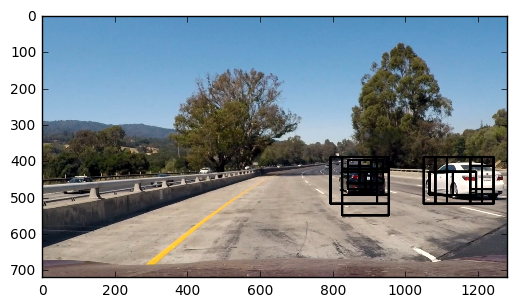

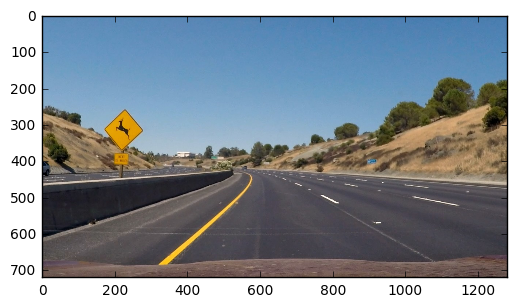

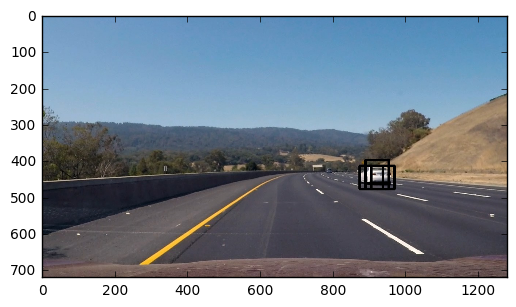

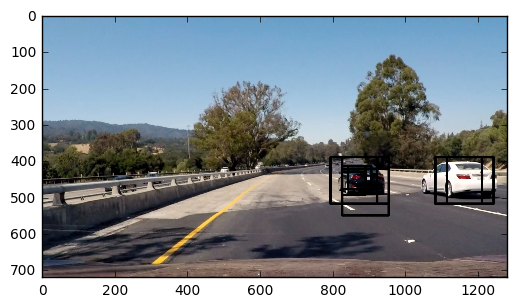

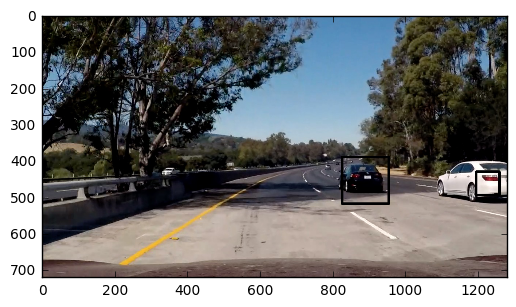

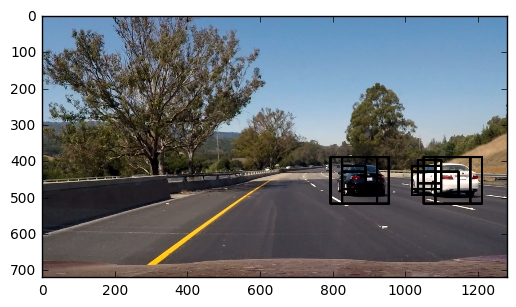

In [21]:
plt.figure()
plt.imshow(product_image_1)
plt.figure()
plt.imshow(product_image_2)
plt.figure()
plt.imshow(product_image_3)
plt.figure()
plt.imshow(product_image_4)
plt.figure()
plt.imshow(product_image_5)
plt.figure()
plt.imshow(product_image_6)

In [22]:
#parameters for heatmap
heatmap_threshold = 0

In [23]:
from scipy.ndimage.measurements import label


def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def apply_Ones(heatmap):
    heatmap[heatmap>0] = 1
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,1,0), 6)
    # Return the image
    return img


 


In [37]:
def video_heatmap(image,video=False,frame=False):
    #image = mpimg.imread(image_fname)
    draw_image= np.copy(image)

    #plt.imshow(draw_image)
    #windows = slide_window(image, x_start_stop = x_start_stop, y_start_stop = y_start_stop, xy_window=(window_size,window_size), xy_overlap=(.5,.5))
   
    windows = slide_window(image, x_start_stop = [600,None], y_start_stop = [350,None], xy_window=(64,64), xy_overlap=(.75,.75))
    #windows = slide_window(image, x_start_stop = [600,None], y_start_stop = [350,None], xy_window=(64,64), xy_overlap=(.75,.75))
    #windows = windows + slide_window(image, x_start_stop = [600,None], y_start_stop = [390,None], xy_window=(80,80), xy_overlap=(.25,.25))
    
    windows_2 = slide_window(image, x_start_stop = [600,None], y_start_stop = [390,None], xy_window=(128,128), xy_overlap=(.75,.75))

    #was previously .6
    hot_windows = search_windows(image, windows, clf, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins,
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat, prediction_threshold=.2)   
    
    hot_windows_2 = search_windows(image, windows_2, clf, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins,
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat,prediction_threshold = .4)   
    
    hot_windows = hot_windows+hot_windows_2
    
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    box_list = hot_windows
    
    # Add heat to each box in box list
    heatmap = add_heat(heat,box_list)
    
    heatmap = apply_threshold(heatmap,0)
    #heatmap = apply_Ones(heatmap)

    
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    #plt.imshow(draw_img)
    #print("finished")
    
    #plt.imshow(labels)
    #print(labels.shape)
    
    if not(video):
        
        return draw_img
       
    else:
        #heat_return = (labels>0)
        if (frame):
            return draw_img,heatmap,box_list
        else:
            return draw_img, heatmap
    


In [25]:
product_image_1 = video_heatmap(image_sample_1)
product_image_2 = video_heatmap(image_sample_2)
product_image_3 = video_heatmap(image_sample_3)
product_image_4 = video_heatmap(image_sample_4)
product_image_5 = video_heatmap(image_sample_5)
product_image_6 = video_heatmap(image_sample_6)

print("done!")

done!


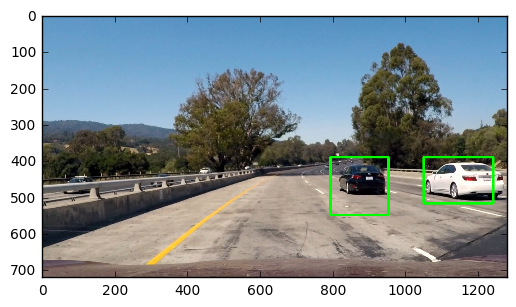

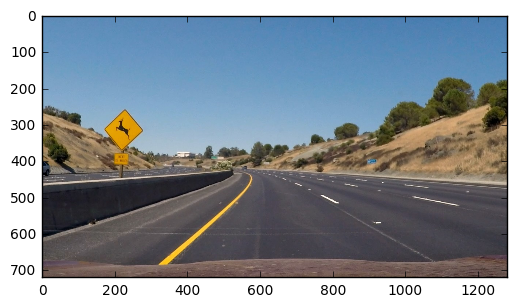

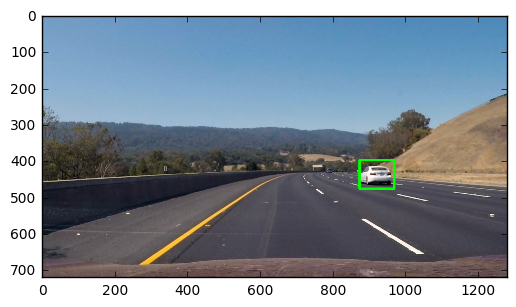

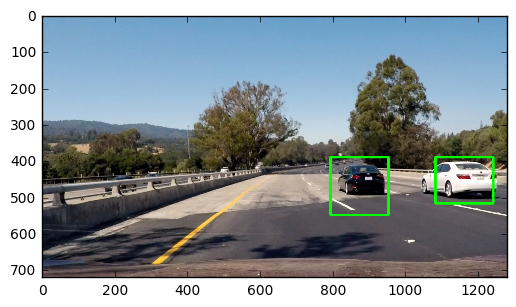

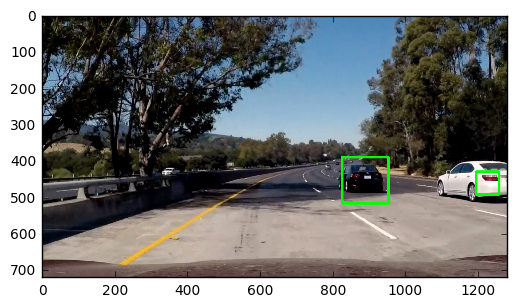

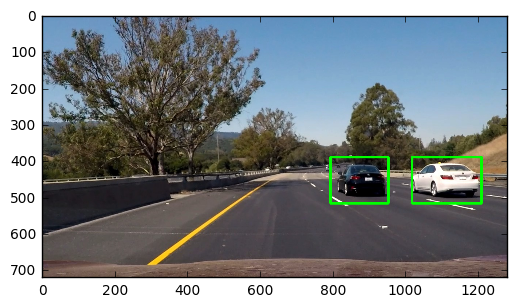

In [26]:
plt.figure()
plt.imshow(product_image_1)
plt.figure()
plt.imshow(product_image_2)
plt.figure()
plt.imshow(product_image_3)
plt.figure()
plt.imshow(product_image_4)
plt.figure()
plt.imshow(product_image_5)
plt.figure()
plt.imshow(product_image_6)

In [45]:
#global currentCycle
#currentCycle=0

def video_frame_label(picture):
    global currentCycle
    global heat_list
    global previousLabel
    global globeCounter
    #print(picture.shape)
    
    heatmap_threshold = 3
    
    picture = picture.astype(np.float32)/255
    
    currentBicycle = currentCycle%5
    
    if currentBicycle==0:
        #print("printing 5th sum")
        currentCycle=1
        
        #print(picture)
        
        labeled_picture = np.zeros_like(picture[:,:,0]).astype(np.float)

        for heater in heat_list:
            labeled_picture = labeled_picture+heater
        
        heat_list = []

        current_heat = apply_threshold(labeled_picture,heatmap_threshold)
        current_heatmap = apply_Ones(current_heat)
        
        current_labels = label(current_heatmap)
        previousLabel = current_labels
        
        draw_img = draw_labeled_bboxes(np.copy(picture), current_labels)     
        
        draw_img = draw_img*255
        
        if globeCounter < 5:
            globeCounter = 10
            final_heatmap_max = current_labels[0].max()
            final_heatmap_out = np.zeros((current_labels[0].shape[0],current_labels[0].shape[1],3))
            final_heatmap_out[:,:,0] = current_labels[0]*(255/final_heatmap_max)
            final_heatmap_out[:,:,1] = current_labels[0]*(255/final_heatmap_max)
            final_heatmap_out[:,:,2] = current_labels[0]*(255/final_heatmap_max)
            cv2.imwrite("./Writeup_images/heatmap/final_labels.png",final_heatmap_out)
            
            draw_img_out = cv2.cvtColor(draw_img,cv2.COLOR_RGB2BGR)

            cv2.imwrite("./Writeup_images/heatmap/final_picture.png",draw_img_out)

        
        #plt.imshow(current_labels[0])
        #plt.imshow(draw_img)
        
        #print("the above should be current labels")
        
        return draw_img
    else:
        currentCycle = currentCycle + 1
        globeCounter = globeCounter +1
        
        _,current_heat,current_boxlist = video_heatmap(picture,video=True,frame=True)
        
        if globeCounter < 5:
            picture_out = draw_boxes(picture, current_boxlist, color=(0, 1, 0), thick=6)

            picture_out = cv2.cvtColor(picture_out*255,cv2.COLOR_RGB2BGR)
            cv2.imwrite("./Writeup_images/heatmap/frame_" + str(globeCounter) + ".png",picture_out)
            
            heatmap_max = current_heat.max()
            heatmap_out = np.zeros((current_heat.shape[0],current_heat.shape[1],3))
            heatmap_out[:,:,0] = current_heat*(255/heatmap_max)
            heatmap_out[:,:,1] = current_heat*(255/heatmap_max)
            heatmap_out[:,:,2] = current_heat*(255/heatmap_max)
            cv2.imwrite("./Writeup_images/heatmap/heat_" + str(globeCounter) + ".png",heatmap_out)


        #plt.imshow(picture)
        #plt.imshow(current_heat,cmap='gray')
        
        
        heat_list.append(current_heat)
        
        draw_img = draw_labeled_bboxes(np.copy(picture), previousLabel)
        
        draw_img = draw_img*255
                
        return draw_img

In [46]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import numpy as np
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

global currentCycle
global heat_list
global previousLabel
global globeCounter

globeCounter = 0
currentCycle = 1
heat_list = []
previousLabel = [[],0]

#selects designated video and runs getLines function on every frame
outputVid = './frame_printer.mp4'
exampleVid = VideoFileClip('./test_video.mp4')
#exampleVid2 = exampleVid.subclip(35,36)
outputClip = exampleVid.fl_image(video_frame_label)

%time outputClip.write_videofile(outputVid,audio=False)

print("done")


[MoviePy] >>>> Building video ./frame_printer.mp4
[MoviePy] Writing video ./frame_printer.mp4


 97%|█████████▋| 38/39 [01:51<00:03,  3.31s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./frame_printer.mp4 

CPU times: user 1min 50s, sys: 456 ms, total: 1min 50s
Wall time: 1min 53s
done
